# Summary

Use this notebook to generate training data.
- (i) initialize an observer (with or without parallax)
- (ii) randomly sample sources and lenses relative to one another
- (iii) observe the source $N_O$ times, creating a list of celestial coordinates, $[\phi, \theta]_i$.
- (iv) repeat this process $N_t$ times

# Downloads

In [1]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload

import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

# Astropy
from astropy import units as u

# lenstools
import lenstools as lt

# Convenient variables
pi   = np.pi
norm = np.linalg.norm
mult = np.matmul
dot  = np.dot

# Parameters

In [210]:
# Don't use Astopy units, for a speedup
units = False

# Training set size
N_t = int(1e2)

In [211]:
# Observer properties

# Number of observations
N_o = 20

# Observation time
t_obs = 5
if units:
    t_obs *= u.yr

# Time increment for observations
dt = t_obs/N_o

# Flag to include parallax or not
#    observer moves along a cirlce of radius 1AU with period 1yr
parallax = True

In [212]:
# Lens properties

# mass parameter of lenses in M_sol
M_l = 1e7

# kind of lens: ['point', 'Gaussian', 'tNFW', 'Burkert']
# Warning: Latter two not implemented yet
kind = 'Gaussian'

# Length scale of lens mass distribution in kpc
R_l = 1e-3

# Length scale of observer-lens distance in kpc
D_ol = 1.

if units:
    M_l *= u.M_sun
    R_l *= u.kpc
    D_ol *= u.kpc

In [213]:
# Source properties

# Length scale of lens-source distance
D_ls = 1.

# Length scale of source impact parameter
D_b = 1.

if units:
    D_ls *= u.kpc
    D_b *= u.kpc

In [214]:
# length scales will be used according to:
#    scale[0] -> uniform distribution of lens distance from observer
#    scale[1] -> uniform distribution of source distance past lens
#    scale[2] -> uniform distribution of source perp distance from 
#                observer-lens axis

scale = [D_ol, D_ls, D_b]

# Example: Lucky Event

Use a reference frame where $z$ is up-down, $x$ is left-right, and $y$ is distance in front or behind. 

So an object straight in front of you (the observer) has only a non-zero $y$ coordinate, and angular coordinates $\theta = \phi = \pi/2$, and $\phi$ will shrink if $x$ grows.

In [215]:
%autoreload
# Create an observer object
obs = lt.Observer(parallax = parallax, units=units)

# Create a Lens that is ~.1 kpc away (in the y-direction), moves
# very fast along the x-axis, and transits over the span of ~5 yrs
lucky_lens = lt.Lens(
    x = np.array([-.05, 100, 0]) * 1e-3,  # in kpc
    v = np.array([2e4, 0, 0]) * (u.km/u.s).to(u.kpc/u.yr),  # in km/s
    kind=kind, M=M_l, R=R_l
) 

# The source is stationary, in the z-y plane, and has a small
# impact parameter (is slightly above the x-y plane)
lucky_src = lt.Source(
    x = np.array([0, 300, 10]) * 1e-3,  # in pc
    v = np.array([0, 0, 0]) * (u.km/u.s).to(u.kpc/u.yr)  # in km/s
)

if units:
    lucky_lens.x *= u.kpc
    lucky_src.x *= u.kpc
    
    lucky_lens.v *= u.kpc/u.yr
    lucky_src.v *= u.kpc/u.yr

In [216]:
# Observe the source without any lensing
res_unlensed = obs.observe(lucky_src)

# Observe the source with lensing
res_lensed = obs.observe(lucky_src, lucky_lens)

# Compare lensed and unlensed observations
if units:
    print('[d\\theta, d\phi]:', (res_lensed-res_unlensed).to(u.mas))
else:
    print('[d\\theta, d\phi]:', (res_lensed-res_unlensed) * u.rad.to(u.mas) * 1e3) 

[d\theta, d\phi]: [-26286.53385684   -394.77436551]


/Users/gregoryridgway/Desktop/AstroML/Astrometric_TSeries_ML/lenstools.py:648: RuntimeWarning: divide by zero encountered in double_scalars
  phi = np.arctan(y/x)


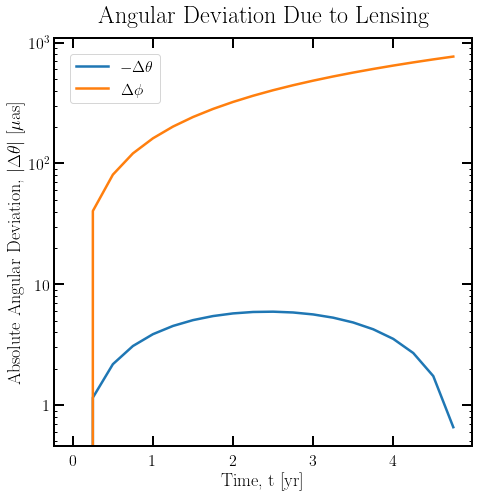

In [217]:
%autoreload
# Now observe multiple times
# Multi-measurements are defined such that \theta_0 and \phi_0
# are subtracted from the list of measurements
# The deviations between lensed/unlensed becomes smaller as a result

res_unlensed = obs.observe(lucky_src, N=N_o, dt=dt)
res_lensed = obs.observe(lucky_src, lucky_lens, N=N_o, dt=dt)

plt.figure(figsize=(7.5,7.5))
# plt.loglog()
plt.yscale('log')

if units:
    times = np.arange(0, t_obs.value, dt.value) * dt.unit
    res = np.array(res_lensed-res_unlensed)
    
else:
    times = np.arange(0, t_obs, dt)
    res = np.array(res_lensed-res_unlensed) * lt.rad_to_muas * 1e-3
    
plt.plot(times, -res[:,0]*1e3, label=r'$-\Delta \theta$')
plt.plot(times, res[:,1]*1e3, label=r'$\Delta \phi$')

plt.xlabel('Time, t [yr]')
plt.ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
plt.title('Angular Deviation Due to Lensing')
plt.legend()

# Example 2: Random Lens and Source

In [138]:
# If you want to see more than just straight lines,
# observe over longer time intervals
N_o = 200

# Observation time
t_obs = 1e5
if units:
    t_obs *= u.yr
    
# Time increment for observations
dt = t_obs/N_o

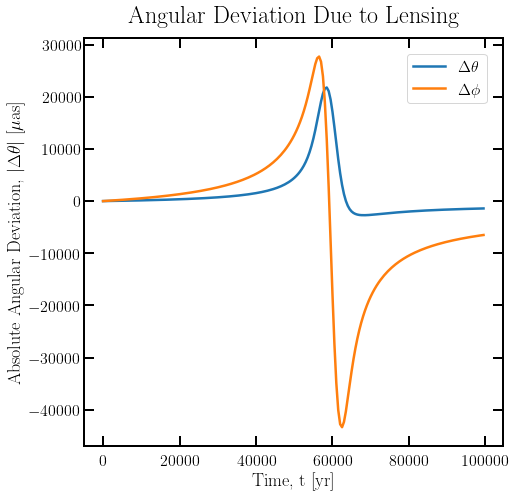

In [140]:
%autoreload

v_esc = lt.v_esc
if units:
    v_esc = v_esc * u.kpc/u.yr

# Try generating a random lens-source pair
lens, src = lt.sample(
    'relative', scale=scale, observer=obs, kind=kind, M=M_l, R=R_l, v_esc=v_esc)

res_unlensed = obs.observe(src, N=N_o, dt=dt)
res_lensed = obs.observe(src, lens, N=N_o, dt=dt)

plt.figure(figsize=(7.5,7.5))
# plt.loglog()

if units:
    times = np.arange(0, t_obs.value, dt.value) * dt.unit
    res = np.array(res_lensed-res_unlensed)
    
    
    
else:
    times = np.arange(0, t_obs, dt)
    res = np.array(res_lensed-res_unlensed) * lt.rad_to_muas * 1e-3
    
plt.plot(times, res[:,0]*1e3, label=r'$\Delta \theta$')
plt.plot(times, res[:,1]*1e3, label=r'$\Delta \phi$')

plt.xlabel('Time, t [yr]')
plt.ylabel(
    r'Absolute Angular Deviation, $|\Delta \theta |$ [$\mu$as]')
plt.title('Angular Deviation Due to Lensing')
plt.legend()

# Generate Training Set

In [233]:
%autoreload
N_t=10000

In [235]:
%%prun

# All data in micro-arcseconds
Tset = np.zeros((N_t, N_o, 2))

# Set the impact parameter scale to something smaller to get 
# more of a signal
scale[2] = 10*1e-3
if units:
    scale[2] *= u.kpc

scale2 = [s for s in scale]

v_esc = lt.v_esc
if units:
    v_esc = v_esc * u.kpc/u.yr
    
lenses = lt.Lenses()
sources = lt.Sources()

# Progress bar
for i in tqdm(np.arange(N_t)):
    lens, src = lt.sample(
        'relative', scale=scale, observer=obs,
        kind=kind, M=M_l, R=R_l, v_esc=v_esc
    )
    
    lenses.append(lens)
    sources.append(src)
    
#     res_unlensed = obs.observe(src, N=N_o, dt=dt)
#     res_lensed = obs.observe(src, lens, N=N_o, dt=dt)

#     Tset[i] = np.array(res_lensed-res_unlensed)

Tset = (
    obs.observe(sources, lenses, N=N_o, dt=dt)  # Lensed images
    - obs.observe(src, N=N_o, dt=dt)  # Unlensed images
)

<string>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

With units, 100 iterations takes about 6.6s.
Without, 1000 iterations takes 2.2s (Also stopped using np.linalg.norm function)
Using Observer.observe on (Sources, Lenses) rather than (Source, Lens), 10000 iterations takes 2.9s (Also stopped using np.linalg.norm function)